In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy

import string
import re

In [2]:
!pip install -q py_stringmatching
import py_stringmatching as sm

     |████████████████████████████████| 661 kB 5.1 MB/s 


# Lezione del 3 Ottobre 2022

In questo notebook vogliamo approfondire il metodo di schema matching basato su Value Overlap, introducendo un modo più efficiente per effettuarlo, basato sulla nozione 
di **set similarity join** (o **string similarity join**) 

In questo modo, anche in caso di  dataset "reali" quali ad esempio

TableA = pd.read_csv('http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/imdb.csv')

TableB = pd.read_csv('http://pages.cs.wisc.edu/~anhai/data/784_data/movies1/csv_files/rotten_tomatoes.csv')

è possibile ottenere il seguente risultato di schema matching basato su Value Overlap:

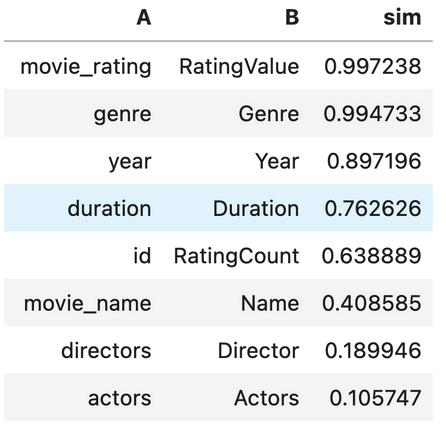

Dopo la sezione preliminare che richiama le funzioni già introdotte,
si introduce la **Extend Jaccard** e quindi il **Set Similarity Join**.

# Schema Matching

## to_sim_table e to_sim_matrix

In [3]:
def sim_table(TableA:pd.DataFrame, TableB:pd.DataFrame):
    A = pd.DataFrame({"A": TableA.columns})
    B = pd.DataFrame({"B": TableB.columns})
    S = A.assign(key=1).merge(B.assign(key=1), on="key").drop("key", axis=1)
    return S
    
def random_sim_table(TableA:pd.DataFrame, TableB:pd.DataFrame):
    S = sim_table(TableA, TableB)
    S["sim"] = np.random.rand(len(S))
    return S


def to_sim_table(SimMatrix:pd.DataFrame):
    return SimMatrix.stack().reset_index(name="sim")

def to_sim_matrix(SimTable:pd.DataFrame):
    return SimTable.pivot(index="A", columns="B", values="sim")

Come abbiamo detto, potete riscrivere queste funzioni;
ad esempio: il prodotto cartesiano può essere fatto senza il "trucco" 
di inserire una chiave comune di joi, ma tramite *how='cross'* come suggerito da MARCO MICHELINI durante la lezione:

In [4]:
def sim_table(TableA:pd.DataFrame, TableB:pd.DataFrame):
    A = pd.DataFrame({"A": TableA.columns})
    B = pd.DataFrame({"B": TableB.columns})
    S = A.merge(B, how='cross')
    return S

## string_preprocess e levenshtein_sim (label-based) 

I nomi A e B delle row a cui si applica il preprocessing delle stringhe sono gli stessi che abbiamo definito per e due table

In [ ]:
def string_preprocess(s:str, char:str=string.punctuation, word:list=[]):
    if type(s) is str:
        s = s.lower()
        for c in char:
            s = s.replace(c, " ")
        for w in word:
            s = s.replace(w, " ")
    else:
        s = str(s)
    s = re.sub(" +", " ", s)
    return s.strip()

def levenshtein_sim(row:pd.Series):
    lev = sm.Levenshtein()
    return lev.get_sim_score(
            string_preprocess(row["A"]),
            string_preprocess(row["B"])
        )

def levenshtein_label_based_similarity(TableA:pd.DataFrame, TableB:pd.DataFrame):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(levenshtein_sim, axis=1)
    return C.sort_values("sim", ascending=False)

## Combined Approaches

Consideriamo l'approccio *Ensemble* che combina la predizione
di più SimTable in una unica SimTable ottenuta tramite
 avg(), min(), or max() 

In [ ]:
def max_sim_table(SimTableList:list):
    ST = pd.DataFrame(columns=["A","B","sim"])
    for x in SimTableList:
        ST = ST.append(x, ignore_index=True)
    return ST.groupby(["A","B"])["sim"].max().reset_index()

def min_sim_table(SimTableList:list):
    ST = pd.DataFrame(columns=["A","B","sim"])
    for x in SimTableList:
        ST = ST.append(x, ignore_index=True)
    return ST.groupby(["A","B"])["sim"].min().reset_index()

def avg_sim_table(SimTableList:list):
    ST = pd.DataFrame(columns=["A","B",'sim'])
    for x in SimTableList:
        ST = ST.append(x, ignore_index=True)
    return ST.groupby(["A","B"])["sim"].mean().reset_index()

## Local Single Attribute Strategies

In [ ]:
def thresholding(SimTable:pd.DataFrame, threshold:float):
    return SimTable[SimTable["sim"] > threshold].sort_values(["sim"], ascending=[False])
    
def top_K(SimTable:pd.DataFrame, K:int, AoB:str="A"):
    MT = deepcopy(SimTable)
    MT["pos"] = MT.sort_values(["sim"], ascending=[False]).groupby(AoB).cumcount()
    return MT[MT["pos"] < K].drop(columns=["pos"]).sort_values([AoB,"sim"], ascending=[True,False])

def top_1(SimTable:pd.DataFrame, AoB:str="A"):
    return top_K(SimTable, 1, AoB)

## Global Matching

Si considerano solo quelli *facili* da formulare, ovvero 
stable_marriage e simmetric_best_match

In [ ]:
def stable_marriage(MatchTable:pd.DataFrame):
    MATCH = pd.DataFrame(columns=["A", "B", "sim"])
    MT = deepcopy(MatchTable)
    MT = MT.sort_values(["sim"], ascending=[False])
    while True:
        R = MT.loc[(~MT["A"].isin(MATCH["A"])) & (~MT["B"].isin(MATCH["B"]))]
        if len(R) == 0:
            break
        x = R.iloc[0,:]
        MATCH = MATCH.append(x, ignore_index=True)
    return MATCH

def simmetric_best_match(MatchTable:pd.DataFrame):
  CMT = deepcopy(MatchTable)

  CMT['A_RowNo'] = CMT.sort_values(['sim'], ascending=[False]) \
             .groupby(['A']) \
             .cumcount() + 1

  CMT['B_RowNo'] = CMT.sort_values(['sim'], ascending=[False]) \
             .groupby(['B']) \
             .cumcount() + 1

  return CMT[(CMT.A_RowNo==1) & (CMT.B_RowNo==1)].drop(columns=['A_RowNo', 'B_RowNo']).sort_values(['sim'], ascending=[False])

# Value Overlap:   Extended Jaccard

Consideriamo la definizione della Value Overlap basata sulla Jaccard *semplice*
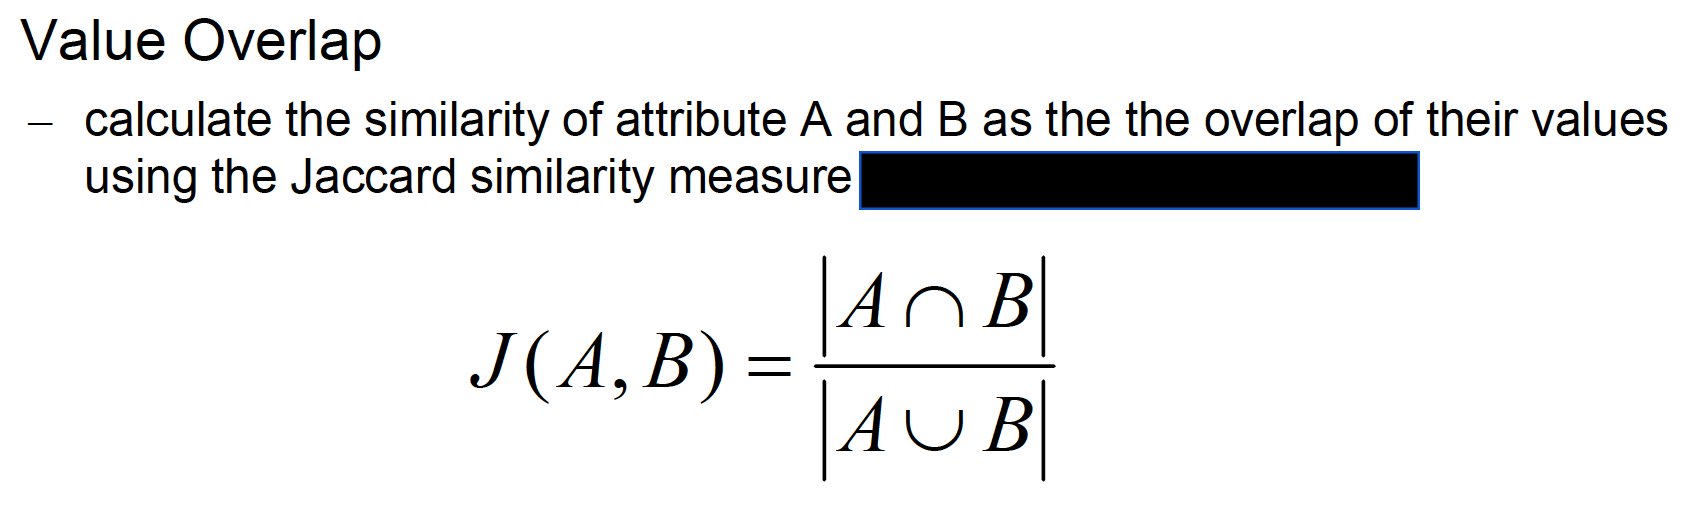


In [ ]:
# Introduciamo un semplice esempio di riferimento considerando due table con un  solo attributo 
TX = pd.DataFrame({'AX': ['prof rossi ugo','rossi ugo ing prof','verde ugo']})
TY = pd.DataFrame({'AY': ['luigi rossi prof','verde ugo','ugo rossi ing']})

jaccard_value_overlap_sim(TX,TY)

A   B  sim
0  AX  AY  0.2

Con la Jaccard *semplice* consideri le coppie uguali (join esatto), con la **Extended Jaccard** consideri le coppie simili sulla base di una funzione di similarità tramite il seguente semplice processo:

1. Calcolo di tutte le coppie di valori:  prodotto cartesiano 

2. Calcolo della similità di ogni coppia: tale similarità si calcola tramite una funzione di similarità (detta funzione di similarità *interna*) 

3. Calcola la **Value Overlap** considerando le coppie come sovrapposte se la loro similarità supera una certa soglia.

In questa definizione la funzione di similarità *interna* può essere qualsiasi, quindi oltre ad una funzione di tipo *edit-based* come  Levenshtein similarity, si possono usare  anche funzioni di similarity di tipo *token-based* come la *Jaccard similarity*!

Le funzioni di similarità mostrate nella figura che segue le vedremo in dettaglio quando faremo l'Entity Resolution , però per completare questo argomento relativo alla Extended Jaccard si introduce anche la Jaccard similarity come funzione di similarità token-based per confrontare due stringhe.









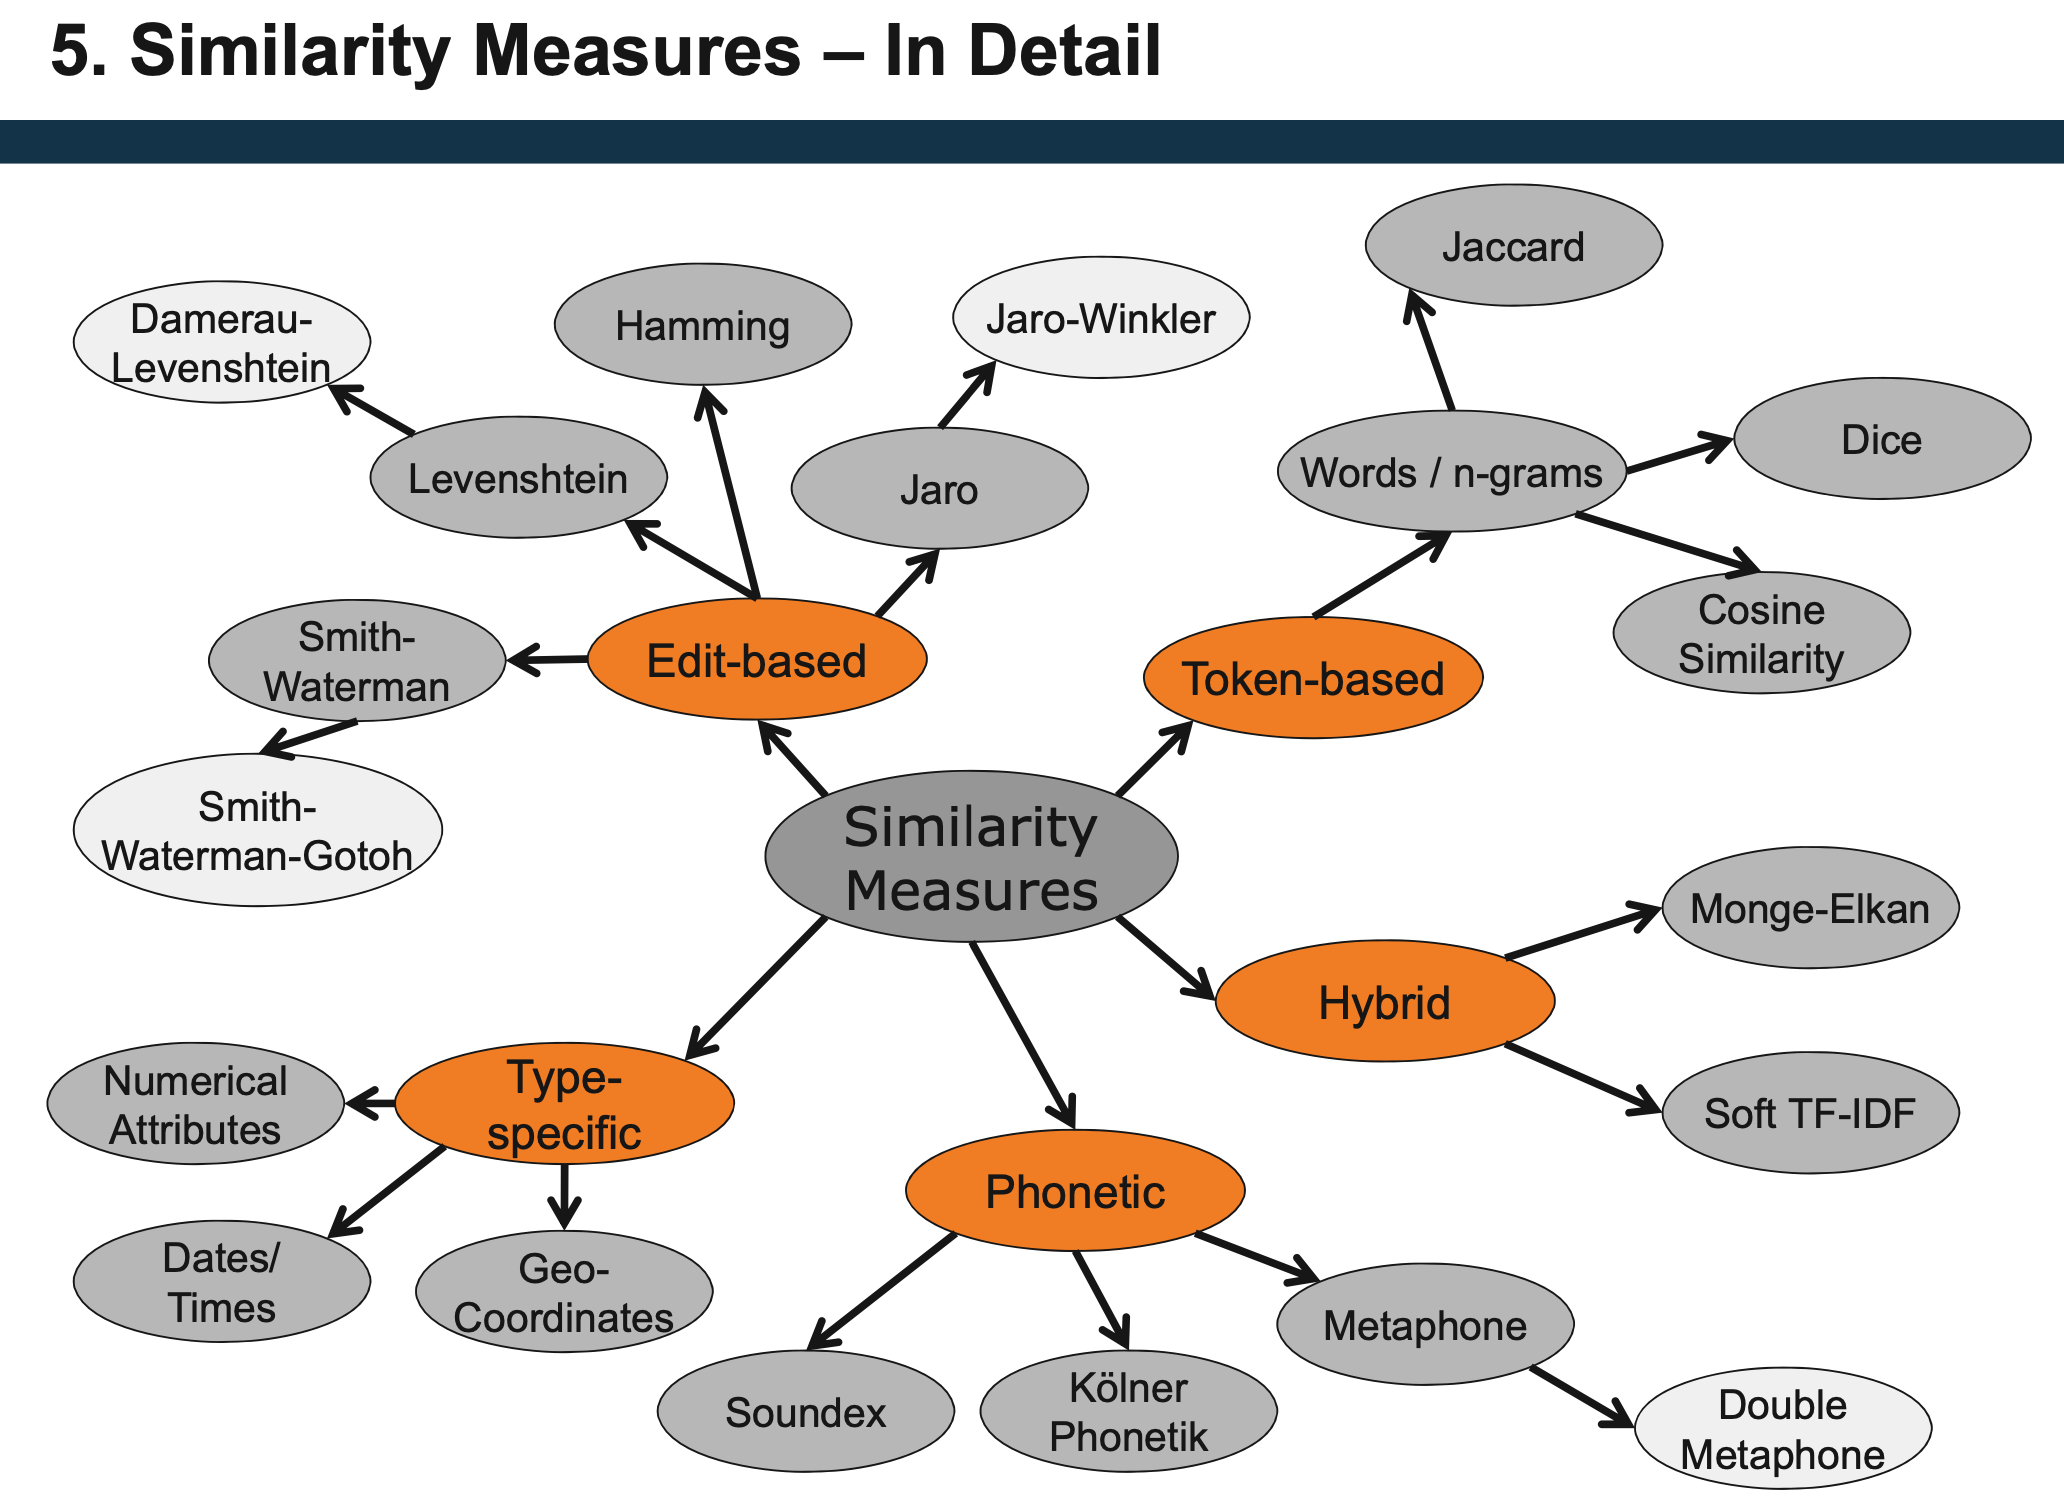

La seguente tabella riassume gli esempi di Value Overlap con Extended Jaccard che verranno presentati in questo notebook (per completezza si mostra anche la Value Overlap basata sulla Generalized Jaccard)

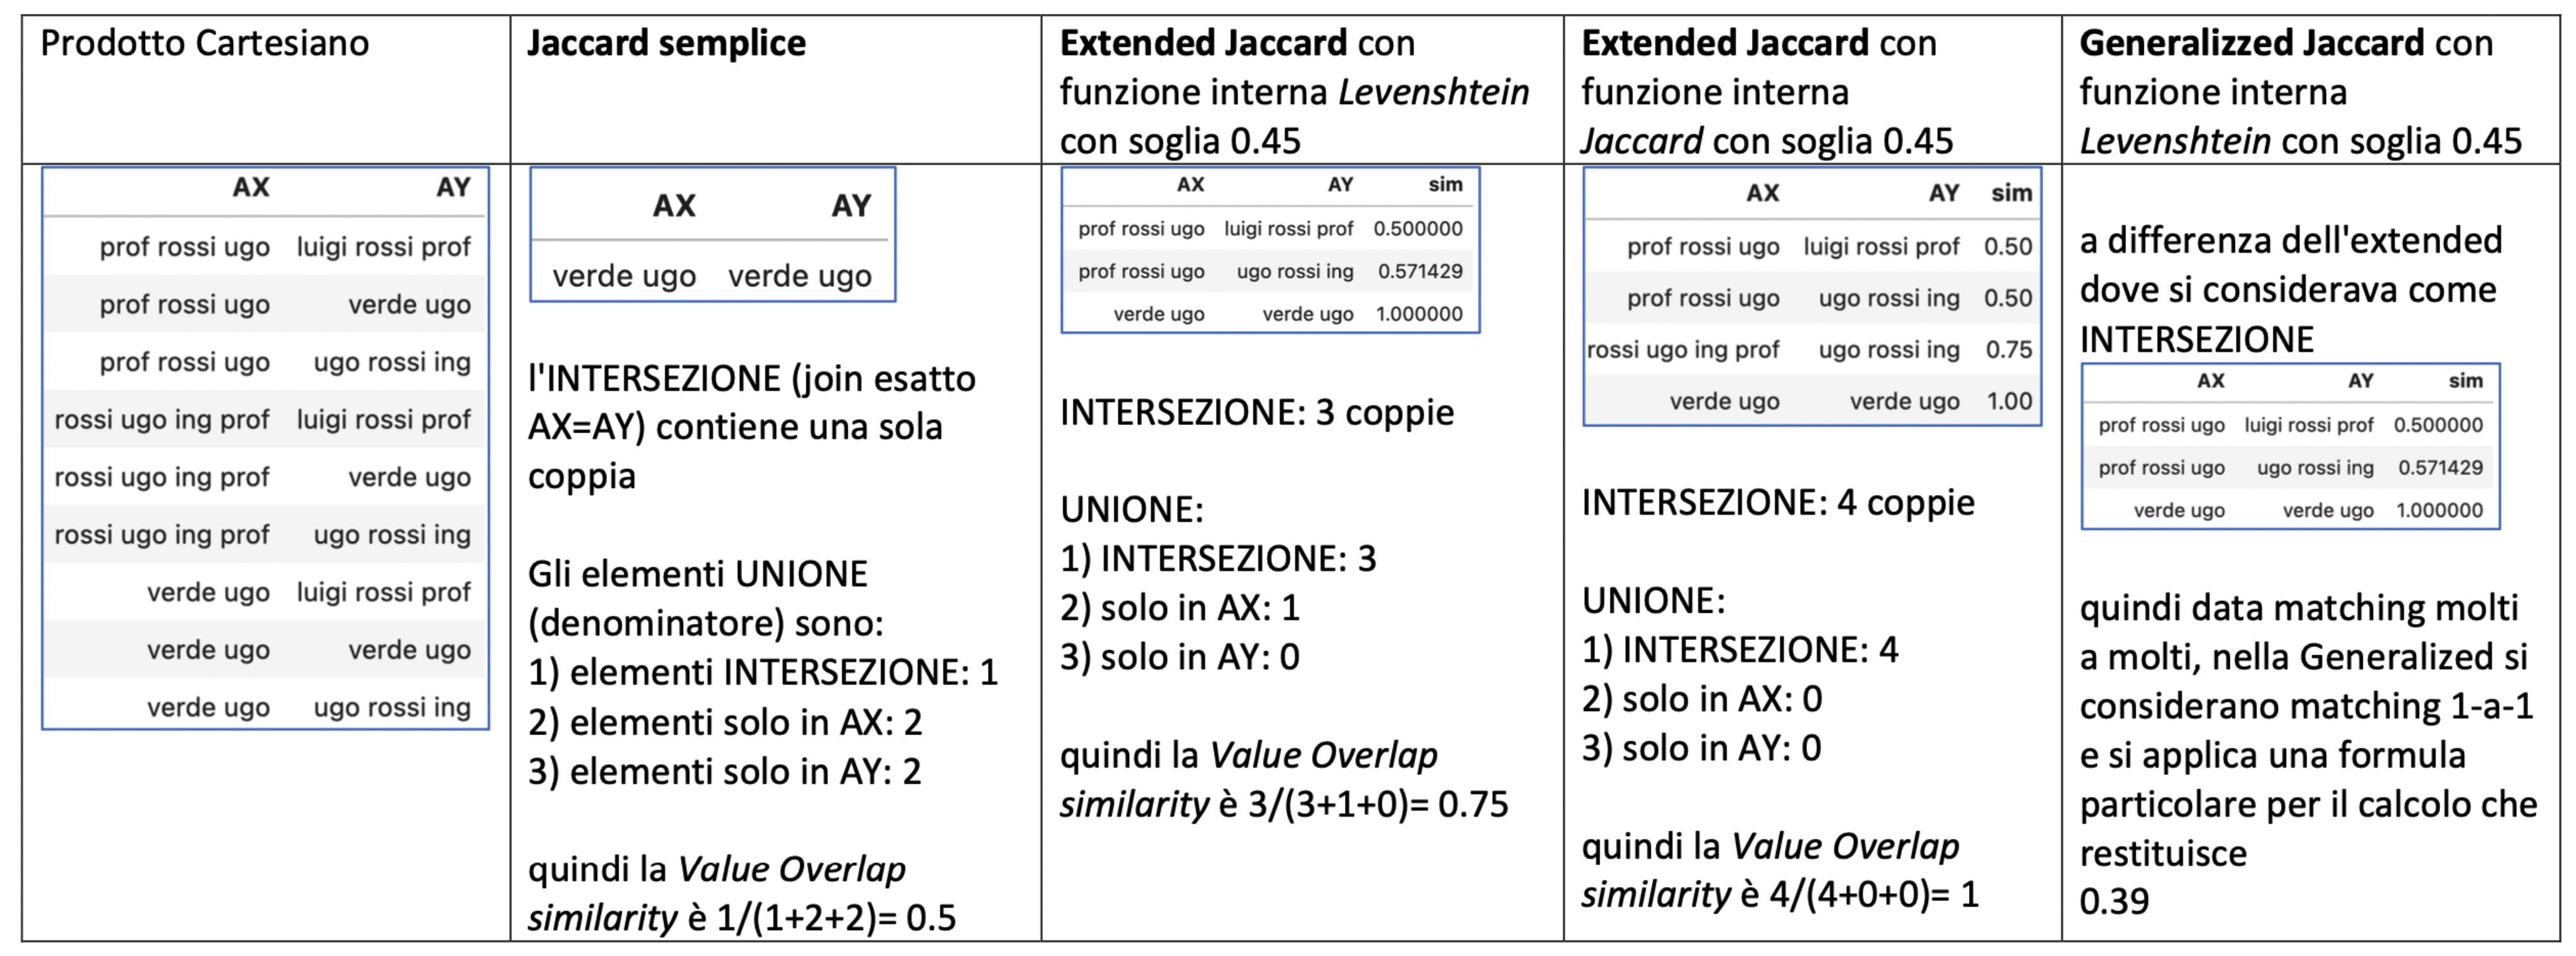

In [ ]:
# 1. Calcolo di tutte le coppie di valori:  prodotto cartesiano 
PCC = TX.drop_duplicates().merge(TY.drop_duplicates(), how='cross')
# si tolgono eventuali duplicati perchè non vogliamo considerarli nel calcolo della Value Overlap
PCC

AX                AY
0      prof rossi ugo  luigi rossi prof
1      prof rossi ugo         verde ugo
2      prof rossi ugo     ugo rossi ing
3  rossi ugo ing prof  luigi rossi prof
4  rossi ugo ing prof         verde ugo
5  rossi ugo ing prof     ugo rossi ing
6           verde ugo  luigi rossi prof
7           verde ugo         verde ugo
8           verde ugo     ugo rossi ing

In [ ]:
# con la Jaccard semplice l'intersezione viene fatta tramite join esatto, quindi:
INTERSEZIONE =  PCC[PCC.AX==PCC.AY].drop_duplicates() # JOIN ESATTO
INTERSEZIONE

AX         AY
7  verde ugo  verde ugo

In [ ]:
# la cardinalità di A UNION B  si può calcolare  dalla cardinalità dell'INTERSEZIONE, len(INTERSEZIONE), - come segue
SoloInAX=PCC.loc[~PCC['AX'].isin(INTERSEZIONE['AX'])][['AX']].drop_duplicates()
SoloInAY=PCC.loc[~PCC['AY'].isin(INTERSEZIONE['AY'])][['AY']].drop_duplicates()
len(SoloInAX)+len(SoloInAY)+len(INTERSEZIONE)

5

In [ ]:
# e quindi la Value Overlap calcolata con la Jaccard semplice risulta essere
len(INTERSEZIONE)/(len(SoloInAX)+len(SoloInAY)+len(INTERSEZIONE))

0.2

Nella Extended Jaccard si considera la similità di ogni coppia
del prodotto cartesiano calcolata  tramite una  funzione di similarità *interna*

In [ ]:
# come primo caso di funzione_similarita_interna usiamo la classica Levenshtein
def funzione_similarita_interna(row:pd.Series):
    lev = sm.Levenshtein()
    return lev.get_sim_score(
            string_preprocess(row["AX"]),
            string_preprocess(row["AY"])
        )

In [ ]:
PCC = TX.drop_duplicates().merge(TY.drop_duplicates(), how='cross')
PCC["sim"] = PCC.apply(funzione_similarita_interna, axis=1)
PCC

AX                AY       sim
0      prof rossi ugo  luigi rossi prof  0.500000
1      prof rossi ugo         verde ugo  0.357143
2      prof rossi ugo     ugo rossi ing  0.571429
3  rossi ugo ing prof  luigi rossi prof  0.444444
4  rossi ugo ing prof         verde ugo  0.222222
5  rossi ugo ing prof     ugo rossi ing  0.277778
6           verde ugo  luigi rossi prof  0.187500
7           verde ugo         verde ugo  1.000000
8           verde ugo     ugo rossi ing  0.153846

In [ ]:
# 3. Calcola la **Value Overlap** considerando le coppie come sovrapposte (e quindi in INTERSEZIONE) 
#    solo se la loro similarità supera una certa soglia.
#    è una semplice selezione delle righe di PCC
INTERSEZIONE =  PCC[PCC.sim>=0.45]
INTERSEZIONE

AX                AY       sim
0  prof rossi ugo  luigi rossi prof  0.500000
2  prof rossi ugo     ugo rossi ing  0.571429
7       verde ugo         verde ugo  1.000000

In [ ]:
# quindi applico la stessa "formula" applicata in precedenza per il calcolo della Value Overlap
SoloInAX=PCC.loc[~PCC['AX'].isin(INTERSEZIONE['AX'])][['AX']].drop_duplicates()
SoloInAY=PCC.loc[~PCC['AY'].isin(INTERSEZIONE['AY'])][['AY']].drop_duplicates()
len(INTERSEZIONE)/(len(SoloInAX)+len(SoloInAY)+len(INTERSEZIONE))

0.75

Si può ovviamente notare come ora la Value Overlap della Extended Jaccard sia maggiore rispetto a quella della semplice jaccard.

In [ ]:
# definiamo una funzione per il calcolo della extend_jaccard_similarity
def extend_jaccard_similarity(TX:pd.DataFrame, TY:pd.DataFrame, threshold:float):
    PCC = TX.drop_duplicates().merge(TY.drop_duplicates(), how='cross')
    PCC["sim"] = PCC.apply(funzione_similarita_interna, axis=1)
    INTERSEZIONE =  PCC[PCC.sim>=threshold]
    SoloInAX=PCC.loc[~PCC['AX'].isin(INTERSEZIONE['AX'])][['AX']].drop_duplicates()
    SoloInAY=PCC.loc[~PCC['AY'].isin(INTERSEZIONE['AY'])][['AY']].drop_duplicates()
    return len(INTERSEZIONE)/(len(SoloInAX)+len(SoloInAY)+len(INTERSEZIONE))

In [ ]:
extend_jaccard_similarity(TX,TY,0.45)

0.75

## Extendended Jaccard, con funzione interna Jaccard con WhitespaceTokenizer 

Finora abbiamo usato come  funzione di similarità *interna* una funzione di tipo *edit-based*, la classica Levenshtein similarity.

Si possono usare  anche funzioni di similarity di tipo *token-based* come la *Jaccard similarity* 
che introduciamo in modo intuitivo nel seguito

Innanzittutto  si introduco i Tokenizer:
https://anhaidgroup.github.io/py_stringmatching/v0.4.x/Tokenizer.html

In [ ]:
# si considera una semplice tokenizzazione basata sulle parole
# per trasformare un valore, una stringa, in una lista di parole
tok = sm.WhitespaceTokenizer(return_set=True)
tok.tokenize("ugo rossi"), tok.tokenize("rossi ugo")

(['ugo', 'rossi'], ['rossi', 'ugo'])

In [ ]:
# su questi insiemi si applica la Jaccard ( quella classica!)
jac=sm.Jaccard()
jac.get_sim_score(tok.tokenize("ugo rossi"), tok.tokenize("rossi ugo"))

1.0

In [ ]:
jac.get_sim_score(tok.tokenize("prof rossi ugo"), tok.tokenize("ugo rossi ing"))

0.5

In [ ]:
# Quindi definiamo la funzione interna tramite Jaccard con WhitespaceTokenizer
def funzione_similarita_interna(row:pd.Series):
    jac=sm.Jaccard()
    tok = sm.WhitespaceTokenizer(return_set=True)
    return jac.get_sim_score(
            tok.tokenize(string_preprocess(row["AX"])),
            tok.tokenize(string_preprocess(row["AY"])))

In [ ]:
# proviamola
TX = pd.DataFrame({'AX': ['prof rossi ugo','rossi ugo ing prof','verde ugo']})
TY = pd.DataFrame({'AY': ['luigi rossi prof','verde ugo','ugo rossi ing']})
PCC = TX.drop_duplicates().merge(TY.drop_duplicates(), how='cross')
PCC["sim"] = PCC.apply(funzione_similarita_interna, axis=1)
INTERSEZIONE =  PCC[PCC.sim>=0.45]
INTERSEZIONE.sort_values('sim', ascending=False)

AX                AY   sim
7           verde ugo         verde ugo  1.00
5  rossi ugo ing prof     ugo rossi ing  0.75
0      prof rossi ugo  luigi rossi prof  0.50
2      prof rossi ugo     ugo rossi ing  0.50

In [ ]:
extend_jaccard_similarity(TX,TY,0.45)

1.0

In [ ]:
#  Ci possono essere ovviamente dei casi in cui funziona meglio la Levenshtein
# ad esempio
TX = pd.DataFrame({'AX': ['prof rossi ugo','rossiugo ing prof','verde ugo']})
TY = pd.DataFrame({'AY': ['luigirossi prof','verde ugo','ugorossi ing']})


In [ ]:
#  Jaccard con WhitespaceTokenizer
def funzione_similarita_interna(row:pd.Series):
    jac=sm.Jaccard()
    tok = sm.WhitespaceTokenizer(return_set=True)
    return jac.get_sim_score(
            tok.tokenize(string_preprocess(row["AX"])),
            tok.tokenize(string_preprocess(row["AY"])))

extend_jaccard_similarity(TX,TY,0.45)

0.2

In [ ]:
#  Levenshtein
def funzione_similarita_interna(row:pd.Series):
    lev = sm.Levenshtein()
    return lev.get_sim_score(
            string_preprocess(row["AX"]),
            string_preprocess(row["AY"])
        )
extend_jaccard_similarity(TX,TY,0.45)

0.75

Concludiamo questa sezione generalizzando il calcolo al caso di generici dataset con più attributi

In [ ]:
TableA = pd.DataFrame({  'A1': ['prof rossi ugo','rossiugo ing prof','verde ugo'],
                          'A2': ['rossi ugo ing prof','verde ugo', 'bianchi gino']})
TableB = pd.DataFrame({ 'B1': ['luigirossi prof','verde ugo'],
                         'B2': ['luigi rossi prof','ugo rossi ing'],
                          'B3': ['luigi rossi prof', 'ugo rossi ing']})

In [ ]:
TableB

B1                B2                B3
0  luigirossi prof  luigi rossi prof  luigi rossi prof
1        verde ugo     ugo rossi ing     ugo rossi ing

In [ ]:
TableA

A1                  A2
0     prof rossi ugo  rossi ugo ing prof
1  rossiugo ing prof           verde ugo
2          verde ugo        bianchi gino

In [ ]:
def funzione_similarita_interna(row:pd.Series): # Jaccard
    jac=sm.Jaccard()
    tok = sm.WhitespaceTokenizer(return_set=True)
    return jac.get_sim_score(
            tok.tokenize(string_preprocess(row["AX"])),
            tok.tokenize(string_preprocess(row["AY"])))


def funzione_similarita_interna(row:pd.Series): # Levenshtein
    lev = sm.Levenshtein()
    return lev.get_sim_score(
            string_preprocess(row["AX"]),
            string_preprocess(row["AY"])
        )


def extended_value_overlap_sim(row:pd.Series, TableA:pd.DataFrame,TableB:pd.DataFrame, threshold:float):
    TX = TableA[[row["A"]]].applymap(string_preprocess).drop_duplicates()
    TY = TableB[[row["B"]]].applymap(string_preprocess).drop_duplicates()
    TX.columns=['AX']
    TY.columns=['AY']
    PCC = TX.drop_duplicates().merge(TY.drop_duplicates(), how='cross')
    PCC["SimJac"] = PCC.apply(funzione_similarita_interna, axis=1)
    INTERSEZIONE =  PCC[PCC.SimJac>=threshold]
    SoloInAX=PCC.loc[~PCC['AX'].isin(INTERSEZIONE['AX'])][['AX']].drop_duplicates()
    SoloInAY=PCC.loc[~PCC['AY'].isin(INTERSEZIONE['AY'])][['AY']].drop_duplicates()
    return len(INTERSEZIONE)/(len(SoloInAX)+len(SoloInAY)+len(INTERSEZIONE))


def value_overlap_extended_jaccard(TableA:pd.DataFrame, TableB:pd.DataFrame, threshold:float):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(extended_value_overlap_sim, args=(TableA, TableB, threshold), axis=1)
    return C.sort_values("sim",ascending=False)

In [ ]:
value_overlap_extended_jaccard(TableA,TableB,0.4)

A   B   sim
0  A1  B1  1.00
1  A1  B2  0.75
2  A1  B3  0.75
3  A2  B1  0.25
4  A2  B2  0.25
5  A2  B3  0.25

In [ ]:
# con soglia 1 si ottiene il join esatto, ovvero lo stesso risultato di jaccard_value_overlap_sim(TableA,TableB)
value_overlap_extended_jaccard(TableA,TableB,1)

A   B   sim
0  A1  B1  0.25
3  A2  B1  0.25
1  A1  B2  0.00
2  A1  B3  0.00
4  A2  B2  0.00
5  A2  B3  0.00

In [ ]:
jaccard_value_overlap_sim(TableA,TableB)

A   B   sim
0  A1  B1  0.25
3  A2  B1  0.25
1  A1  B2  0.00
2  A1  B3  0.00
4  A2  B2  0.00
5  A2  B3  0.00

Considerato che il metodo Value Overlap deve confrontare in genere moltissimi valori,
quelli contenuti negli attributi dei dataset, il vantaggio di usare come  funzione di similarità *interna* una funzione di tipo *token-based* - in cui la similarità è definita su insiemi di oggetti - risiede nel fatto che il calcolo può essere ottimizzato tramite il concetto di *Set Similarity Join*.


# Set Similarity Join

Il **Set Similarity Join** è introddotto nelle slide
https://moodle.unimore.it/pluginfile.php/466188/course/section/30324/Set%20Similarity%20Join_SIWS_2022.pdf


Applichiamo la tecnica del String Similarity Join al nostro contesto utilizzando la seguente libreria disponibile in Magellan;



## String Similarity Join: [py_stringsimjoin](http://anhaidgroup.github.io/py_stringsimjoin/v0.1.x/overview.html)

In [ ]:
!pip install py_stringsimjoin 
import py_stringsimjoin as ssj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def sim__join(row:pd.Series, TableA:pd.DataFrame,TableB:pd.DataFrame, threshold:float):
    TX = TableA[[row["A"]]].applymap(string_preprocess).drop_duplicates()
    TY = TableB[[row["B"]]].applymap(string_preprocess).drop_duplicates()
    TX.columns=['AX']
    TY.columns=['AY']
    
    INTERSEZIONE  = ssj.jaccard_join(     TX, TY, # tabelle su cui effettuare il sim join
                                'AX', 'AY', # chiavi delle tabelle 
                                'AX', 'AY', # attributi di join
                                  sm.WhitespaceTokenizer(return_set=True),
                                  threshold=threshold, 
                                  show_progress=False,
                                  l_out_attrs=['AX'],  r_out_attrs=['AY']
                           )
    SoloInAX=TX.loc[~TX['AX'].isin(INTERSEZIONE['l_AX'])][['AX']].drop_duplicates()
    SoloInAY=TY.loc[~TY['AY'].isin(INTERSEZIONE['r_AY'])][['AY']].drop_duplicates()
    return len(INTERSEZIONE)/(len(SoloInAX)+len(SoloInAY)+len(INTERSEZIONE))


def value_overlap_simjoin_jaccard(TableA:pd.DataFrame, TableB:pd.DataFrame, threshold:float):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(sim__join, args=(TableA, TableB, threshold), axis=1)
    return C.sort_values("sim",ascending=False)

In [ ]:
X=value_overlap_simjoin_jaccard(TableA,TableB,0.7)

/usr/local/lib/python3.7/dist-packages/py_stringsimjoin/utils/generic_helper.py:77: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  subset=[join_attr])


In [ ]:
to_sim_matrix(X)

B     B1    B2    B3
A                   
A1  0.25  0.00  0.00
A2  0.25  0.25  0.25

In [ ]:
TableA=pd.read_csv("http://dbgroup.ing.unimore.it/SIWS/MOVIE/rotten_tomatoes_m1.csv")
TableB=pd.read_csv("http://dbgroup.ing.unimore.it/SIWS/MOVIE/imdb_m3.csv")

In [ ]:
TableA.columns

Index(['Id', 'Name', 'Year', 'Release Date', 'Director', 'Creator', 'Actors',
       'Cast', 'Language', 'Country', 'Duration', 'RatingValue', 'RatingCount',
       'ReviewCount', 'Genre', 'Filming Locations', 'Description'],
      dtype='object')

In [ ]:
TableB.columns

Index(['ID', 'Title', 'Year', 'Rating', 'Director', 'Creators', 'Cast',
       'Genre', 'Duration', 'ContentRating', 'Summary'],
      dtype='object')

In [ ]:
TX = TableA[['Name']].applymap(string_preprocess).drop_duplicates()
TY = TableB[['Title']].applymap(string_preprocess).drop_duplicates()
TX.columns=['AX']
TY.columns=['AY']

# calcolo INTERSEZIONE come string similarity join
INTERSEZIONE  = ssj.jaccard_join(     TX, TY, # string similarity join
                                    'AX', 'AY', # chiavi delle tabelle 
                                    'AX', 'AY', # attributi di join
                                      sm.WhitespaceTokenizer(return_set=True),
                                      threshold=0.5, 
                                      show_progress=False,
                                      l_out_attrs=['AX'],  r_out_attrs=['AY']
                           )
INTERSEZIONE

/usr/local/lib/python3.7/dist-packages/py_stringsimjoin/utils/generic_helper.py:77: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  subset=[join_attr])


_id                   l_AX                   r_AY  _sim_score
0        0              12 rounds               12 12 12        0.50
1        1         21 jump street         21 jump street        1.00
2        2         22 jump street         21 jump street        0.50
3        3  3 2 1 frankie go boom  3 2 1 frankie go boom        1.00
4        4      the abcs of death      the abcs of death        1.00
...    ...                    ...                    ...         ...
3936  3936            world war z            world war z        1.00
3937  3937          world war z 2            world war z        0.75
3938  3938             wrong turn                  wrong        0.50
3939  3939            you re next            you re next        1.00
3940  3940         you re not you            you re next        0.50

[3941 rows x 4 columns]

# Per riassumere

In [ ]:
TX = pd.DataFrame({'AX': ['prof rossi ugo','rossi ugo ing prof','verde ugo']})
TY = pd.DataFrame({'AY': ['luigi rossi prof','verde ugo','ugo rossi ing']})


In [ ]:
TY

AY
0  luigi rossi prof
1         verde ugo
2     ugo rossi ing

In [ ]:
# jaccard semplice, basata su confronto esatto

In [ ]:
jaccard_value_overlap_sim(TX,TY)

A   B  sim
0  AX  AY  0.2

In [ ]:
# Extendended Jaccard, con funzione interna Levenshtein 
def funzione_similarita_interna(row:pd.Series):
    lev = sm.Levenshtein()
    return lev.get_sim_score(
            string_preprocess(row["AX"]),
            string_preprocess(row["AY"])
        )
value_overlap_extended_jaccard(TX,TY,0.45)

A   B   sim
0  AX  AY  0.75

In [ ]:
## Extendended Jaccard, con funzione interna Jaccard con WhitespaceTokenizer 
def funzione_similarita_interna(row:pd.Series):
    jac=sm.Jaccard()
    tok = sm.WhitespaceTokenizer(return_set=True)
    return jac.get_sim_score(
            tok.tokenize(string_preprocess(row["AX"])),
            tok.tokenize(string_preprocess(row["AY"])))
value_overlap_extended_jaccard(TX,TY,0.45)

A   B  sim
0  AX  AY  1.0

In [ ]:
# che può essere calcolato tramte similarity join
value_overlap_simjoin_jaccard(TX,TY,0.45)

/usr/local/lib/python3.7/dist-packages/py_stringsimjoin/utils/generic_helper.py:77: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  subset=[join_attr])


A   B  sim
0  AX  AY  1.0

## Jaccard Generalizzata : GeneralizedJaccard (argomento facoltativo)
 
[http://anhaidgroup.github.io/py_stringmatching/v0.4.1/GeneralizedJaccard.html](http://anhaidgroup.github.io/py_stringmatching/v0.4.1/GeneralizedJaccard.html)

Per la definizione della Jaccard Generalizzata vedere
[Capitolo Libro su String Matching](https://dolly.ingmo.unimore.it/2020/pluginfile.php/5835/mod_folder/content/0/Principles%20of%20Data%20Integration_BOOK_Doan_Halevy_Ives/4-String-Matching_2012_Principles-of-Data-Integration.pdf?forcedownload=1)

In [ ]:
def generalized_sim(row:pd.Series, TableA:pd.DataFrame, TableB:pd.DataFrame, threshold:float):
    j = sm.GeneralizedJaccard(
            sim_func=sm.Levenshtein().get_sim_score,
            threshold=threshold
        )
    return j.get_raw_score(
            TableA[row["A"]].apply(string_preprocess).tolist(),
            TableB[row["B"]].apply(string_preprocess).tolist()
        )

def generalized_value_overlap_sim(TableA:pd.DataFrame, TableB:pd.DataFrame, threshold:float):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(generalized_sim, args=(TableA, TableB, threshold), axis=1)
    return C.sort_values("sim", ascending=False)

In [ ]:
generalized_value_overlap_sim(TX,TY,0.45)

A   B       sim
0  AX  AY  0.392857

In [ ]:
# verifichiamolo applicando direttamente la funzione
gj = sm.GeneralizedJaccard(sim_func=sm.Levenshtein().get_sim_score, threshold=0.45)
gj.get_sim_score(['prof rossi ugo','rossi ugo ing prof','verde ugo'],
                     ['luigi rossi prof','verde ugo','ugo rossi ing'])


0.39285714285714285

In [ ]:
# perchè così inferiore alla  Extendended Jaccard, con funzione interna Levenshtein ?
def funzione_similarita_interna(row:pd.Series):
    lev = sm.Levenshtein()
    return lev.get_sim_score(
            string_preprocess(row["AX"]),
            string_preprocess(row["AY"])
        )
value_overlap_extended_jaccard(TX,TY,0.45)

A   B   sim
0  AX  AY  0.75

nella Extendended Jaccard con funzione interna Levenshtein l'intersezione ha i seguenti tre elementi:


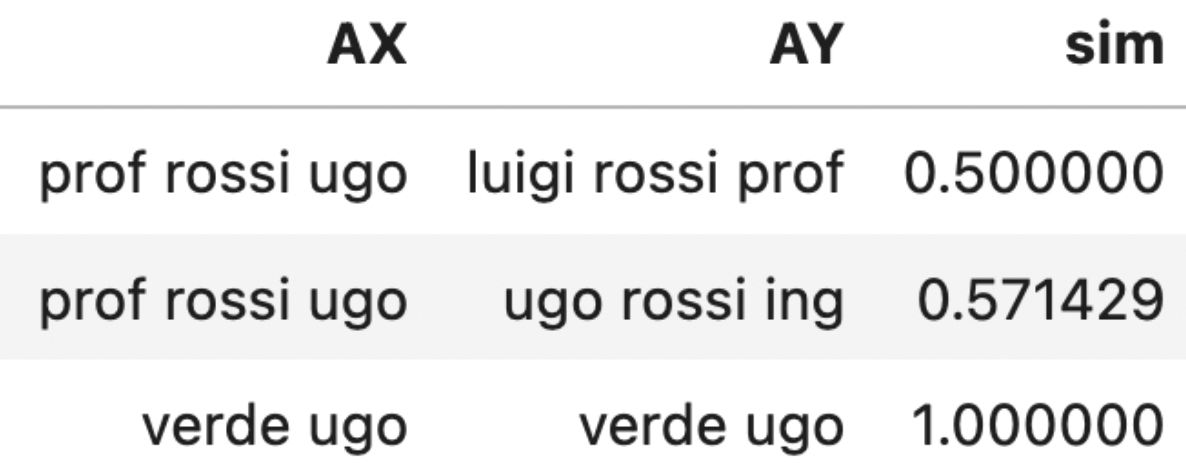

si può notare che uno stesso elemento viene messo in corrispondenza con più elementi (matching molti-a-molti)
mentre nella generalized si considera un matching uno-a-uno, come si può intuire dalla figura :

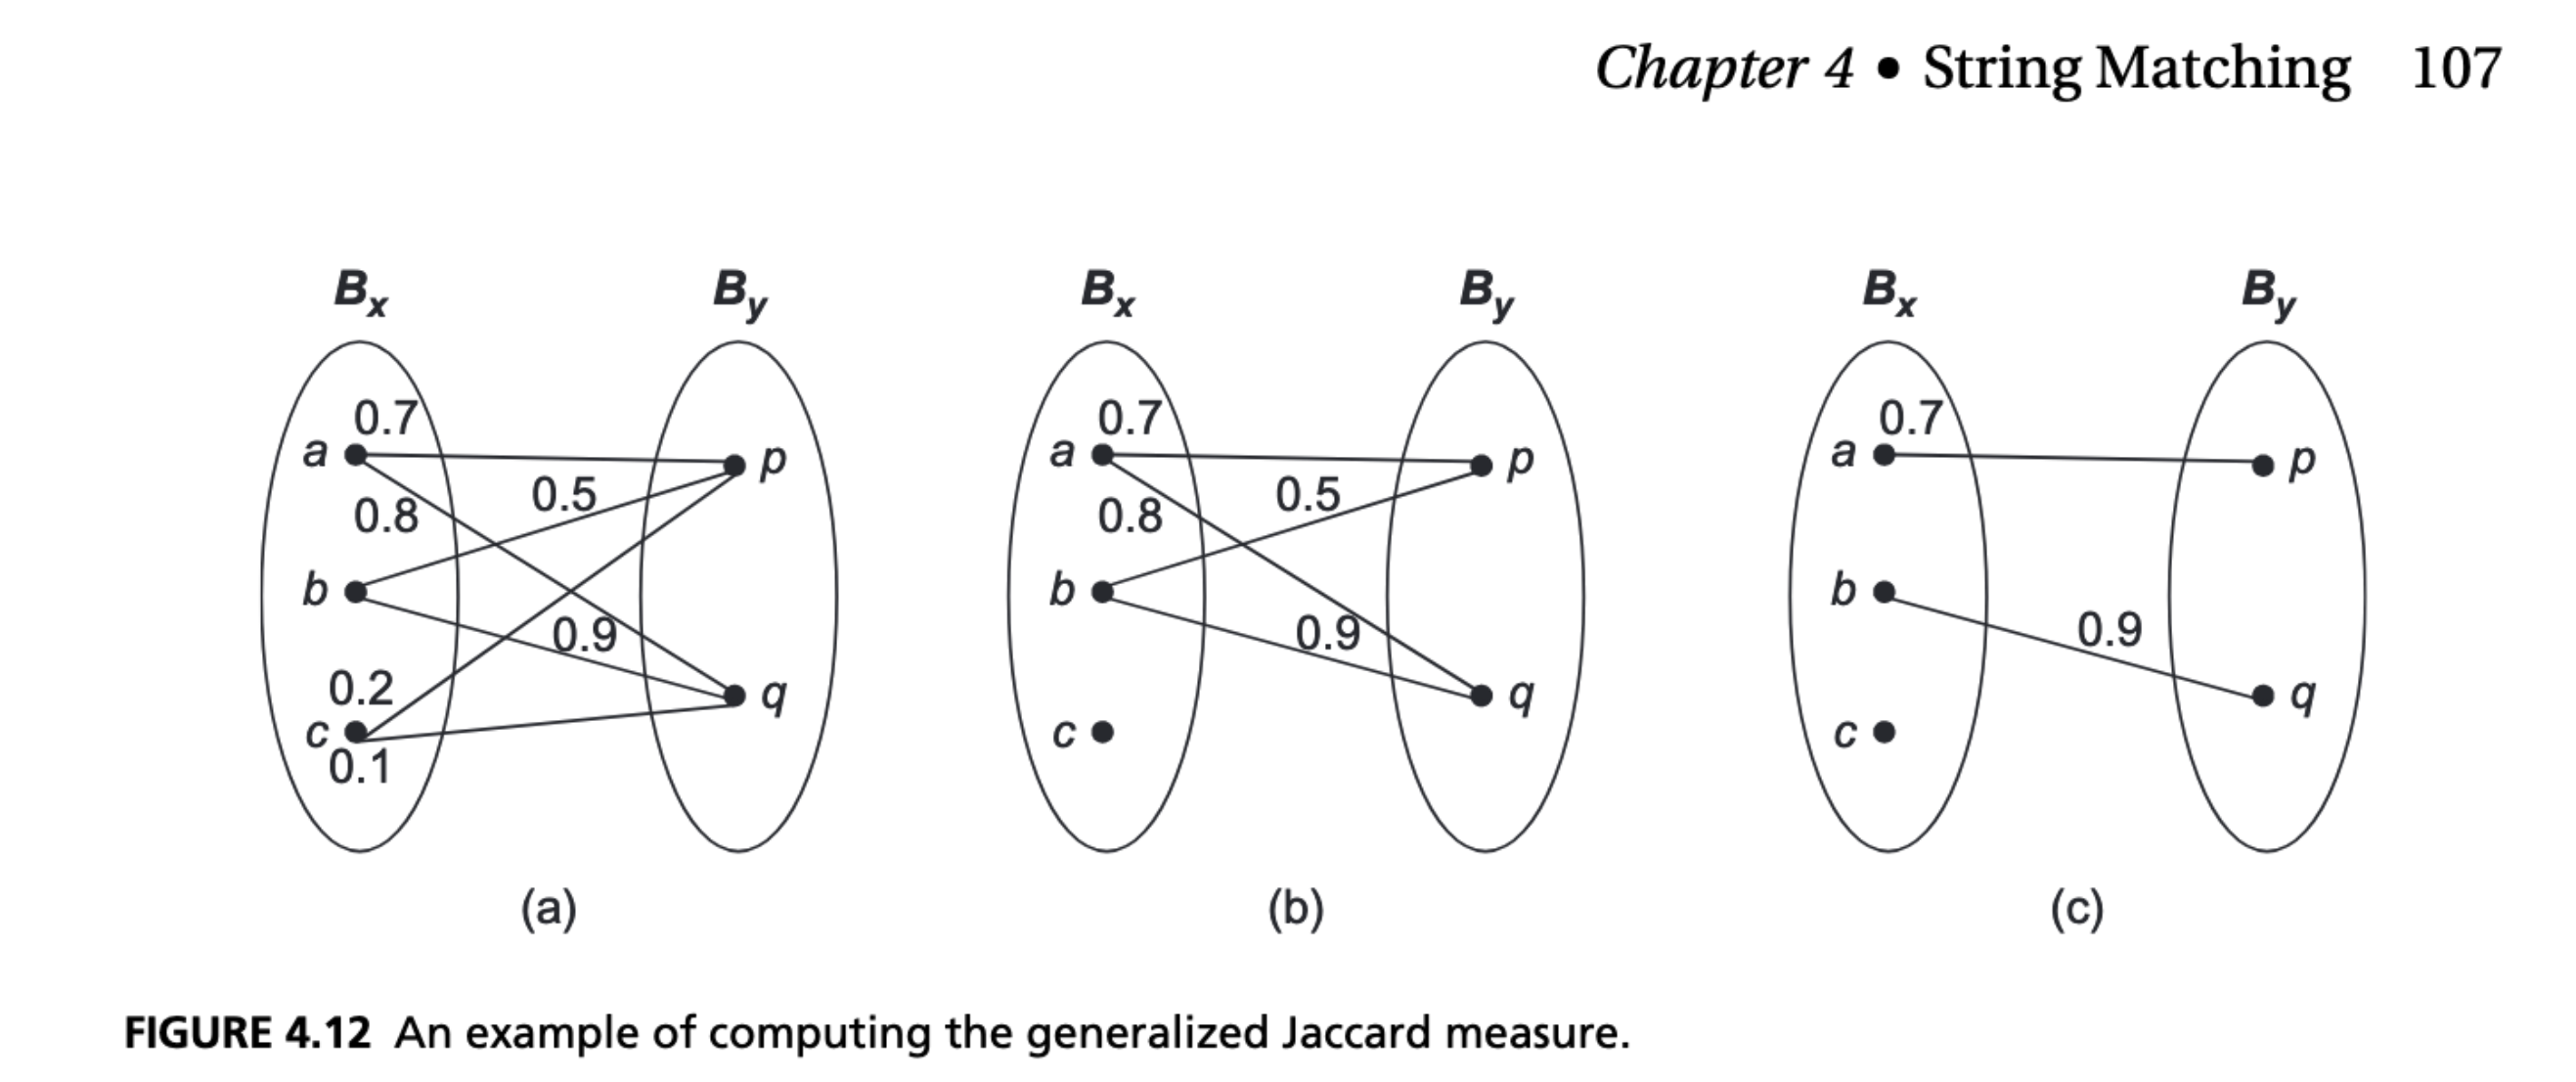

Abbiamo introdotto la  GeneralizedJaccard solo per completezza. 
Nel caso reale (vedi esempio che segue) l'Overlap Value verrà calcolato 
tramite similarity join

# Esempio reale : Movie dataset

Si considerano alcuni dataset disponibili in Magellan

https://sites.google.com/site/anhaidgroup/useful-stuff/the-magellan-data-repository


(oppure 
[http://pages.cs.wisc.edu/~anhai/data/784_data/](http://pages.cs.wisc.edu/~anhai/data/784_data/))


Ogni dataset, quale ad esempio *movie5* 
```
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/imdb.csv', 
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/roger_ebert.csv', 
```

è costituito da due file csv utilizzati per il processo di Entity Resolution del corso di  Anhai Doan (si noti infatti che tra i file forniti c'è anche un labelled_data che verrà usato per l'Entity Resolution basata su Machine Learning).

Questi due dataset dello stesso progetto movie5, 
sono di fonti differenti (imdb e roger_ebert) ma comunque sono stati scelti in modo da avere delle sovrapposizioni, cioè uno stesso film presente in entrambi. Questa è una considerazione importante, in quanto si  può supporre che tra alcune coppie di attributi dei due differenti file ci sia un overlap che possiamo sfruttare nei metodi di Instance-based schema matching : Value Overlap


D'altra parte si nota che la stessa fonte, ad esempio imdb, è utilizzata 
in differenti dataset/progetti movie5, movie3, movie1

```
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/imdb.csv', 
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies3/csv_files/imdb.csv',
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies1/csv_files/imdb.csv']
```

Gli attributi e le istanze sono differenti,


```
movie 5 Source: IMDB                                                             
    Number of records: 6913                                                    
    Attributes: [id, movie_name, year, directors, actors, movie_rating, genre,
                 duration]

movie 3     Source: IMDB                                                  
    Number of records: 2960                                                     
    Attributes: [ID, Title, Year, Rating, Director, Creators, Cast, Genre,
                 Duration, ContentRating, Summary]  

```


ma anche qui si può ipotizzare una certa sovrapposizione essendo la stessa fonte.

In definitiva, in questo esempio l'applicazione dei metodi di schema matching basati sulle istanze sembra essere promettente;
d'altra parte verificheremo i metodi introdotti, anche quello basato sul similarity join, richiedono un tempo di esecuzione considerevole.

Per questo motivo, il passo successivo sara' quello di introdurre un nuovo metodo sempre basato sulle istanze ma che usa tecniche di machine learning

In [ ]:
src_links = [
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/imdb.csv', 
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/roger_ebert.csv', 
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies1/csv_files/rotten_tomatoes.csv', 
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies3/csv_files/rotten_tomatoes.csv',
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies4/csv_files/amazon.csv',
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies3/csv_files/imdb.csv',
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies1/csv_files/imdb.csv']

#SOURCES = { 'S'+str(i+1) : pd.read_csv(link).astype(str) for i, link in enumerate(src_links) }

SOURCES = { i : pd.read_csv(link).astype(str) for i, link in enumerate(src_links) }

## Gold Standard

E' stato realizzato un Gold Standard con tutti i match tra i sette dataset elencati in precedenza. Lo useremo la prossima volta per valutare precision/recall.
Ora solo a titolo qualitativo.

In [ ]:
GoldStandard=pd.read_csv('http://dbgroup.ing.unimore.it/SIWS/DataIntegration/Movie_MTGS.csv')

GoldStandard.loc[GoldStandard['SOURCE'] == 0, 'SOURCE_NAME'] = 'imdb_m5.csv'
GoldStandard.loc[GoldStandard['SOURCE'] == 1, 'SOURCE_NAME'] = 'roger_ebert_m5.csv'
GoldStandard.loc[GoldStandard['SOURCE'] == 2, 'SOURCE_NAME'] = 'rotten_tomatoes_m1.csv'
GoldStandard.loc[GoldStandard['SOURCE'] == 3, 'SOURCE_NAME'] = 'rotten_tomatoes_m3.csv'
GoldStandard.loc[GoldStandard['SOURCE'] == 4, 'SOURCE_NAME'] = 'amazon_m4.csv'
GoldStandard.loc[GoldStandard['SOURCE'] == 5, 'SOURCE_NAME'] = 'imdb_m3.csv'
GoldStandard.loc[GoldStandard['SOURCE'] == 6, 'SOURCE_NAME'] = 'imdb_m1.csv'

In [ ]:
# movies5/csv_files/imdb.csv
print(SOURCES[0].columns.tolist())
# movies3/csv_files/imdb.csv'
print(SOURCES[5].columns.tolist())

['id', 'movie_name', 'year', 'directors', 'actors', 'movie_rating', 'genre', 'duration']
['ID', 'Title', 'Year', 'Rating', 'Director', 'Creators', 'Cast', 'Genre', 'Duration', 'ContentRating', 'Summary']


In [ ]:
# per vedere il gold standard relativo a queste due sources
A0=GoldStandard[GoldStandard.SOURCE==0][['GAT','LAT']]
A5=GoldStandard[GoldStandard.SOURCE==5][['GAT','LAT']]
GoldStandard_0_5=pd.merge(A0,A5,on='GAT')[['LAT_x','LAT_y']]
GoldStandard_0_5.columns=['A','B']
GoldStandard_0_5

A         B
0         genre     Genre
1      duration  Duration
2          year      Year
3  movie_rating    Rating
4    movie_name     Title
5     directors  Director
6        actors      Cast

In [ ]:
# movies5/csv_files/imdb.csv
print(SOURCES[0].columns.tolist())
# movies1/csv_files/rotten_tomatoes.csv'
print(SOURCES[2].columns.tolist())

['id', 'movie_name', 'year', 'directors', 'actors', 'movie_rating', 'genre', 'duration']
['Id', 'Name', 'Year', 'Release Date', 'Director', 'Creator', 'Actors', 'Cast', 'Language', 'Country', 'Duration', 'RatingValue', 'RatingCount', 'ReviewCount', 'Genre', 'Filming Locations', 'Description']


In [ ]:
A0=GoldStandard[GoldStandard.SOURCE==0][['GAT','LAT']]
A2=GoldStandard[GoldStandard.SOURCE==2][['GAT','LAT']]
GoldStandard_0_2=pd.merge(A0,A2,on='GAT')[['LAT_x','LAT_y']]
GoldStandard_0_2.columns=['A','B']
GoldStandard_0_2


A            B
0         genre        Genre
1      duration     Duration
2          year         Year
3  movie_rating  RatingValue
4    movie_name         Name
5     directors     Director
6        actors       Actors
7        actors         Cast

In [ ]:
stable_marriage(X)

A   B   sim
0  A1  B1  0.25
1  A2  B2  0.25

In [ ]:
VO_05=value_overlap_simjoin_jaccard(SOURCES[0],SOURCES[5],0.5)


/usr/local/lib/python3.7/dist-packages/py_stringsimjoin/utils/generic_helper.py:77: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  subset=[join_attr])


In [ ]:
def stable_marriage(MatchTable:pd.DataFrame):
    MATCH = pd.DataFrame(columns=["A", "B", "sim"])
    MT = deepcopy(MatchTable)
    MT = MT.sort_values(["sim"], ascending=[False])
    while True:
        R = MT.loc[(~MT["A"].isin(MATCH["A"])) & (~MT["B"].isin(MATCH["B"]))]
        if len(R) == 0:
            break
        x = R.iloc[0,:]
        MATCH = MATCH.append(x, ignore_index=True)
    return MATCH

stable_marriage(VO_05[VO_05.sim>0])

A         B       sim
0  movie_rating    Rating  0.997167
1         genre     Genre  0.986774
2      duration  Duration  0.622449
3            id        ID  0.428323
4    movie_name     Title  0.251673
5     directors  Director  0.105444
6        actors      Cast  0.058686
7          year      Year  0.055400

In [ ]:
VO_02=value_overlap_simjoin_jaccard(SOURCES[0],SOURCES[2],0.5)
stable_marriage(VO_05[VO_05.sim>0])

/usr/local/lib/python3.7/dist-packages/py_stringsimjoin/utils/generic_helper.py:77: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  subset=[join_attr])


A         B       sim
0  movie_rating    Rating  0.997167
1         genre     Genre  0.986774
2      duration  Duration  0.622449
3            id        ID  0.428323
4    movie_name     Title  0.251673
5     directors  Director  0.105444
6        actors      Cast  0.058686
7          year      Year  0.055400